# Designing Quantum Algorithms with Second Order Functions: A Flexible QPE

Quantum Phase Estimation (QPE) is a fundamental quantum function, at the core of the Shor, HHL, and amplitude estimation algorithms. QPE is a second order function, getting a quantum function $U$ and returning an estimation of its eigenvalues. (Recall that any quantum function represents a unitary matrix.) A QPE that encodes the eigenvalues on $m$ qubits involves a series of $m$ controlled operations of $U^{2^k}$ with $0\leq k < m-1$. This quantum advantage based on the QPE function relies on an ability to implement the power of a given unitary $U$ efficiently. Otherwise, naive $U$ is called $\sum^{m-1}_{k=0} 2^k=2^m$ times &ndash; a number 
that is exponential in the number of qubits.

**This tutorial shows how to leverage declarative and programmatic modeling for exploring the QPE function in the context of Hamiltonian simulation.**

Start with basic import:

In [ ]:
from classiq import (
    CInt,
    H,
    QArray,
    QBit,
    QCallable,
    apply_to_all,
    control,
    invert,
    qft,
    qfunc,
    repeat,
)

## 1. Defining a Flexible QPE

Define a flexible QPE function. Instead of getting a single operand $U$, it gets a parametric operand, $U(p)$, where $p$ is an integer such that $U(p)\equiv U^p$. That is, the power logic of $U$ passes explicitly with the function. In addition, the QPE itself has an integer parameter for the phase register size.

<center>
<img src="https://docs.classiq.io/resources/qpe_flexible.png" style="width:95%">
<figcaption align = "middle"> A Flexible QPE, a rolled-up (left) and a rolled-down (right) layouts. </figcaption>
</center>

In [2]:
@qfunc
def my_qpe_flexible(
    unitary: QCallable[CInt, QArray[QBit]],
    state: QArray[QBit],
    phase: QArray[QBit],
) -> None:
    apply_to_all(H, phase)

    repeat(
        count=phase.len,
        iteration=lambda index: control(
            ctrl=phase[index],
            stmt_block=lambda: unitary(2**index, state),
        ),
    )

    invert(
        lambda: qft(phase),
    )

## 2. Example QPE for Finding the Eigenvalues of an Hermitian Matrix

One use of the QPE is to find the eigenvalues of a given Hermitian matrix $H$. Canonical use cases: (a) the HHL algorithm for solving linear equations $H\cdot \vec{x}=\vec{b}$, where the matrix eigenvalues need to be stored on a quantum register, and (b) finding the minimal energy of a molecule Hamiltonian $H$, preparing an initial guess for an eigenvector followed by a QPE that aims to detect the minimal eigenvalue.

In both use cases, a QPE is performed on *Hamiltonian evolution* $U=e^{2\pi i H}$.

### 2.1 Hamiltonian Evolution

Hamiltonian evolution, or Hamiltonian simulation, is one of the promising uses of quantum computers, where the advantage over classical approaches is clear and transparent (as proposed by Richard Feynman in 1982). Nevertheless, constructing a quantum program for efficient Hamiltonian dynamics is not an easy task. The most common examples use approximated product formulas such as the Trotter-Suzuki (TS) formulas.

#### 2.1.1 Trotter-Suzuki of Order 1

Write the Hamiltonian as a sum of Pauli strings $H=\sum_{i=0}^{L-1} a^{(k)} P^{(k)}$,
where $a^{(k)}$ are complex coefficients, and each of $P^{(k)}$ is a Pauli string of the form $s_0\otimes s_1\otimes\dots\otimes s_L$, with $s_i\in \{I, X, Y, Z\}$. Approximating Hamiltonian simulation with TS of order 1 refers to:
$$
e^{2\pi i H}\approx \left(\Pi^{L-1}_{i=0}e^{\frac{a^{(k)}}{r} P^{(k)}}\right)^r,
$$
where $r$ is called the *number of repetitions*.

* *Given a Hamiltonian and a functional error $\epsilon$, what is the required number of repetitions?*

Apparently, this is not easy to answer. The literature provides several bounds for the number of repetitions for a given functional error and error metric; however, typically, these bounds are very rough, far from representing the actual number of repetitions to use. See Ref.[[1](#Errors)] for a comprehensive study.

* *When performing a QPE, the challenge is even more pronounced*:


For the QPE, a series of Hamiltonian simulations with an exponentially growing evolution coefficient, $e^{2\pi i H}, \, e^{2^1 2\pi i H}, \, e^{2^2 2\pi i H}, \dots, e^{2^{m-1}2\pi i H}$, is required. Which product formula to use for each step, assuming you keep the same error per step?

Lacking good theoretical bounds for the aforementioned questions, resort to experimental exploration in the hope of finding theoretical clues and insights:

#### 2.1.2 A Flexible TS for Plugging into the Flexible QPE

The Trotter-Suzuki of order 1 function, $\text{TS}_1$, gets an Hamiltonian $H$, evolution coefficient $t$, and repetition $r$. Define a wrapper function:

$$
\tilde{\text{TS}}_1\left(H,t,p \right) := \text{TS}_1\left(H,pt,r=f(p)\right).
$$

The function $f(p)$ tries to capture how many repetitions can approximate $\left(e^{2\pi i H}\right)^p=e^{p 2\pi i H}$. Section 2.2 defines the "goodness of approximation".


Define ansatz for the repetition scaling $f(p)$:
\begin{equation}
f(p)\equiv \left\{
\begin{array}{l l}
r_0 & \text{if  } p<p_0,  \\       
r_0 \left\lceil {\left(p/p_0\right)^\gamma}\right\rceil & \text{if  } p\geq p_0
\end{array}
\right. , 
\end{equation}
where $r_0$, $p_0$, and $\gamma$ are parameters to tune.

In [ ]:
from classiq import (
    CReal,
    Output,
    Pauli,
    PauliTerm,
    QNum,
    allocate,
    prepare_amplitudes,
    suzuki_trotter,
)
from classiq.qmod.symbolic import Piecewise, ceiling


def suzuki_trotter_with_power_logic(
    hamiltonian,
    pw: CInt,
    evolution_coefficient: CReal,
    order: CInt,
    target: QArray[QBit],
    p_0: int,
    gamma: float,
    r0: int,
) -> None:
    suzuki_trotter(
        hamiltonian,
        evolution_coefficient=evolution_coefficient * pw,
        order=1,
        repetitions=Piecewise(
            (r0, pw < p_0), (ceiling(r0 * (pw / p_0) ** gamma), True)
        ),
        qbv=target,
    )

### 2.2 QPE Performance

In this tutorial, the measure for goodness of approximation refers to the functionality of the full QPE function, rather than taking a rigorous operator norm per each Hamiltonian simulation step in the QPE. Ways of examining the approximated QPE:
1. By its ability to approximate an eigenvalue for a given eigenvector.
2. By comparing its resulting phase state with the one that results from a QPE with an exact Hamiltonian evolution, using a swap test.
  


## 3. Exploring a Specific Example

Consider a specific Hamiltonian defined with the `PauliOperator` object

In [4]:
import numpy as np

from classiq.applications.chemistry import PauliOperator

paulis = [
    ("II", 0.4),
    ("IZ", -0.05),
    ("IX", -0.03),
    ("ZZ", -0.06),
    ("XZ", 0.04),
    ("XX", -0.16),
    ("YY", -0.06),
]

po = PauliOperator(pauli_list=paulis)

Define auxiliary functions for parsing the PauliOperator object.

In [5]:
from typing import cast

my_list = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def pauli_str_to_enums(pauli):
    return [my_list[s] for s in pauli]


def pauli_operator_to_hamiltonian(pauli_operator):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_operator.pauli_list
    ]

For the demonstration, choose one of the eigenvectors of the matrix, and test the result of the approximated QPE with respect to the expected eigenvalue.

In [6]:
a_mat = po.to_matrix().real
w, v = np.linalg.eig(a_mat)

chosen_eig = 2
print("chosen eigenvector:", v[:, chosen_eig])
print("the eigenvalue to estimate:", w[chosen_eig])

chosen eigenvector: [0.54233721 0.48935737 0.47765123 0.4881076 ]
the eigenvalue to estimate: 0.2096699009257637


***
*Note: For this example, the most naive upper bound for TS formula of order 1 and error $\epsilon=0.1$ (defined by a spectral norm) gives $r=O(4t^2)$ [[2](#TS)], with $t=2\pi$ for the first QPE step. This corresponds to $r_0\sim 160$, and the following QPE steps grow exponentially $r_k\sim 160\times 4^k$. The result is a huge circuit depth, which you can relax by tuning the parameters of the ansatz.*

*Tighter bounds based on commutation relations[[1](#Errors)] can give more reasonable numbers. However, the main purpose of this tutorial is to highlight the advantages of abstract, high-level modeling. Indeed, any known bound can be incorporated in the flexible Trotter-Suzuki by defining $f(m)$ accordingly.*
***

### 3.1. Eigenvalue Estimation

Choose parameters for the power-logic function $f(p)$, construct and synthesize a model, and visualize the resulting quantum program.

In [ ]:
from classiq import execute, show, synthesize

QPE_SIZE = 5
p_0 = 2 ** (QPE_SIZE - 3)
R0 = 4  # according to the naive bound this should be O(150)
GAMMA = 1.5  # according to the naive bound this should be 4


@qfunc
def main(phase_approx: Output[QNum]) -> None:
    state = QArray("state")
    allocate(QPE_SIZE, phase_approx)
    prepare_amplitudes(v[:, chosen_eig].tolist(), 0.0, state)
    my_qpe_flexible(
        unitary=lambda pw, target: suzuki_trotter_with_power_logic(
            hamiltonian=pauli_operator_to_hamiltonian(po),
            pw=pw,
            evolution_coefficient=-2 * np.pi,
            order=1,
            r0=R0,
            p_0=p_0,
            gamma=GAMMA,
            target=target,
        ),
        state=state,
        phase=phase_approx,
    )


qprog_1 = synthesize(main)

In [8]:
show(qprog_1)

Opening: https://platform.classiq.io/circuit/2twgM9u4Qe6gkNIse0v2TFOjpty?version=0.70.0


Execute the quantum program and examine the results: 

In [9]:
result_1 = execute(qprog_1).result_value()

In [10]:
parsed_counts = result_1.parsed_counts
phase_counts = {
    sampled_state.state["phase_approx"] / (2**QPE_SIZE): sampled_state.shots
    for sampled_state in parsed_counts
}

exact eigenvalue: 0.2096699009257637
approximated eigenvalue: 0.21875


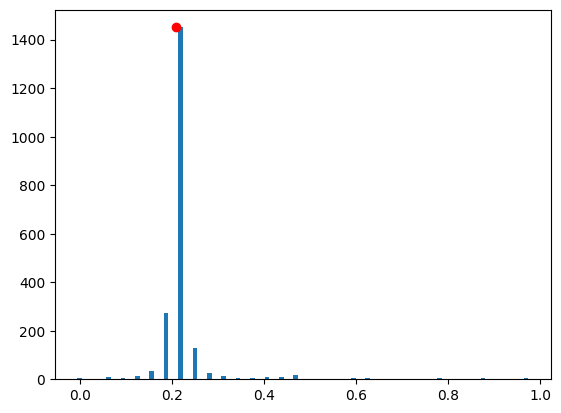

In [11]:
import matplotlib.pyplot as plt

plt.bar(phase_counts.keys(), phase_counts.values(), width=0.01)
most_probable_phase = max(phase_counts, key=phase_counts.get)
plt.plot(w[chosen_eig], phase_counts[most_probable_phase], "or")
print("exact eigenvalue:", w[chosen_eig])
print("approximated eigenvalue:", most_probable_phase)

Indeed, the approximated Hamiltonian simulation seems to be sufficient to find the eigenvalue.

### 3.2. QPE State with Exact Hamiltonian Simulation Versus Approximated

Define the following quantum function: an exact Hamiltonian simulation with power-logic. 

In [ ]:
from typing import List

from classiq import CArray, power, swap_test, unitary


@qfunc
def unitary_with_power_logic(
    pw: CInt, matrix: CArray[CArray[CReal]], target: QArray[QBit]
) -> None:
    power(pw, lambda: unitary(elements=matrix, target=target))

Continue with the same parameters from above for $f(p)$. Construct a model that calls two QPEs in parallel; one with an approximated Hamiltonian simulation and the other with an exact one. Finally, perform a swap test between the resulting phases. Synthesize the model and visualize the resulting quantum program.

In [13]:
import scipy


@qfunc
def main(test: Output[QBit]) -> None:
    state = QArray("state")
    phase_approx = QArray("phase_approx")
    phase_exact = QArray("phase_exact")
    allocate(QPE_SIZE, phase_approx)
    allocate(QPE_SIZE, phase_exact)
    prepare_amplitudes(v[:, chosen_eig].tolist(), 0.0, state)
    my_qpe_flexible(
        unitary=lambda pw, target: suzuki_trotter_with_power_logic(
            hamiltonian=pauli_operator_to_hamiltonian(po),
            pw=pw,
            evolution_coefficient=-2 * np.pi,
            order=1,
            r0=R0,
            p_0=p_0,
            gamma=GAMMA,
            target=target,
        ),
        state=state,
        phase=phase_approx,
    )
    my_qpe_flexible(
        unitary=lambda arg0, arg1: unitary_with_power_logic(
            matrix=scipy.linalg.expm(2 * np.pi * 1j * po.to_matrix()).tolist(),
            pw=arg0,
            target=arg1,
        ),
        state=state,
        phase=phase_exact,
    )

    swap_test(state1=phase_exact, state2=phase_approx, test=test)


qprog_2 = synthesize(main)

In [14]:
show(qprog_2)

Opening: https://platform.classiq.io/circuit/2twgP5ve4rRtodhWwUgorm8Mk8l?version=0.70.0


Execute and examine the results.

In [15]:
result_2 = execute(qprog_2).result_value()

In [16]:
test_counts = result_2.counts

The overlap between the two input states of the swap test, $\psi_1$, $\psi_2$, is given by
$$
Prob(\text{test qubit at state } |0\rangle) = \frac{1}{2}\left(
1+\left|\langle \psi_1 |\psi_2\rangle\right|^2\right)
$$

In [17]:
print("Fidelity (overlap):", 2 * test_counts["0"] / sum(test_counts.values()) - 1)

Fidelity (overlap): 0.958984375


The results are good. You can try to reduce the $r_0$ and/or $\gamma$ parameters, and experimentally study the relation between the functional error and circuit depth.

## 4. Comment

* This tutorial focused on the Trotter-Suzuki formula of order 1 for approximating the Hamiltonian simulation. You can test other implementations, including their "power-logic", such as higher order TS formulas, qDRIFT, or a combination of TS and qDRIFT.

## References

<a name='Errors'>[1]</a>: [Childs, Andrew M., et al. Theory of Trotter error with commutator scaling. PRX 11 (2021): 011020.](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011020)

<a name='TS'>[2]</a>: [Childs, Andrew M., et al. Toward the first quantum simulation with quantum speedup. PNAS 115 9456 (2018).](https://www.pnas.org/doi/abs/10.1073/pnas.1801723115)
